In [ ]:
import json
import requests
import time
from random import seed
from random import randint

import pickle
import pandas as pd

Please read the documentation of the inspire API https://github.com/inspirehep/rest-api-doc . In particular, pay attention to the limit of the rate of requests.

# First, explore the structure of records



Pull a random record:

In [ ]:
api_url = "https://inspirehep.net/api/literature/299873"
response = requests.get(api_url)
rawdata=response.json()

Check the key structure:

In [ ]:
rawdata.keys()

dict_keys(['uuid', 'id', 'revision_id', 'updated', 'created', 'links', 'metadata'])

In [ ]:
rawdata['metadata'].keys()

dict_keys(['citation_count_without_self_citations', 'publication_info', 'report_numbers', 'citation_count', 'dois', 'titles', '$schema', 'authors', 'curated', 'texkeys', 'citeable', 'keywords', 'refereed', 'abstracts', 'references', 'document_type', 'preprint_date', 'control_number', 'legacy_version', 'number_of_pages', 'legacy_creation_date', 'external_system_identifiers'])

In [ ]:
rawdata['metadata']['citation_count']

3

In [ ]:
rawdata['metadata']['document_type']

['article']

In [ ]:
rawdata['metadata']['titles'][0]['title']

'Microscopic study of the alpha- O-16 interaction on the basis of the complex effective interaction and the totally antisymmetrized many-body theory'

In [ ]:
rawdata['metadata']['abstracts'][0]['value']

'The complex internucleus potential for α−16O system is investigated with the microscopic complex effective interaction and the totally antisymmetrized many-body theory. Both real and imaginary parts of the theoretical potential, in which the differences between the oscillator-width parameters of the target and the projectile are taken into account, coincide well with the phenomenological optical potential which is uniquely determined by the experimental results. As for the incident-energy dependence of the real part of internucleus potential, it is found that 70% is caused by the effect of antisymmetrization and that the rest is explained by the energy dependence of the effective interaction. For the imaginary part both the effect of antisymmetrization and the energy dependence of the effective interaction almost equally contribute to the incident-energy dependence.'

In [ ]:
rawdata['metadata']['preprint_date']

'1990-10'

# Main Scrapper



We will only care about: title, date, citations, and abstract. So here's a function that selects these and drops the rest.

In [ ]:
def dropdata(data):
  try:
    dict={'title':data['metadata']['titles'][0]['title'],'date':data['metadata']['preprint_date'],'citations':data['metadata']['citation_count'],'abstract':data['metadata']['abstracts'][0]['value']}
    return dict
  except:
    #If the record doesn't contain the data we're looking for, just return nothing.
    return

Here's a function pulling $k$ random records from inspire. Please respect the waiting time prescribed by the inspirehep API.

In [ ]:
def pulldata(k):
  #First we create a list of random records without duplicates
  rands=[]
  api_url = "https://inspirehep.net/api/literature/"
  for i in range(k):
    rands=rands+[randint(0,1638345)]
  rands=list(set(rands))

  #Now we go through the list of random records and pull the record
  outputdata=[]
  for i in range(len(rands)):
    temp_url = api_url+str(rands[i])
    response = requests.get(temp_url)
    outputdata=outputdata+[response.json()]
    print('\r',end='i:{}'.format(i))
    time.sleep(0.5)

  return outputdata

In [ ]:
#Calls dropdata on a list of multiple records, drops the missing ones
def batchdropdata(datas):
  cd=[]
  for w in datas:
    cw=dropdata(w)
    if cw!=None:
      cd=cd+[cw]
  return cd

In [ ]:
#Drop records that didn't exist for some reason.
def dropwrongs(datas):
  x=[]
  for data in datas:
    if 'message' in data:
      if data['message']=='PID does not exist.':
        pass
    else:
      x=x+[data]
  return x

In [ ]:
mydata1=pulldata(20)

i:19

In [ ]:
cleandata=batchdropdata(dropwrongs(mydata1))

In [ ]:
len(cleandata)

12

In [ ]:
cleandata[:3]

[{'abstract': 'We have assembled a multi-frequency database by cross-correlating the NVSS catalog of radio sources with the RASSBSC list of soft X-ray sources, obtaining optical magnitude estimates from the Palomar and UK Schmidt surveys as provided by the APM and COSMOS on-line services. By exploiting the nearly unique broad-band properties of High-Energy Peaked (HBL) BL Lacs we have statistically identified a sample of 218 objects that is expected to include about 85% of BL Lacs and that is therefore several times larger than all other published samples of HBLs. Using a subset (155 objects) that is radio flux limited and statistically well-defined we have derived the \\vovm distribution and the LogN-LogS of extreme HBLs (fx/fr >= 3E-10 erg/cm2/s/Jansky) down to 3.5 mJy. We find that the LogN-LogS flattens around 20 mJy and that <V/Vm> = 0.42 +/- 0.02. This extends to the radio band earlier results, based on much smaller X-ray selected samples, about the anomalous cosmological observa

Let's save our cleaned data.

In [ ]:
with open("cleandata.json", "w") as write_file:
    json.dump(cleandata, write_file, indent=4)

In [ ]:
from google.colab import files
files.download('cleandata.json')

# Some statistics

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

Let's check the distribution of abstract lengths!

In [ ]:
alens=[len(c['abstract']) for c in cleandata]

(array([ 59., 232., 404., 621., 638., 547., 510., 408., 349., 258., 219.,
        189., 134., 144., 100., 102.,  45.,   3.,   5.,   7.,   9.,   3.,
          4.,   1.,   2.,   0.,   0.,   0.,   1.,   1.,   1.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   1.,   1.]),
 array([  16.  ,  129.94,  243.88,  357.82,  471.76,  585.7 ,  699.64,
         813.58,  927.52, 1041.46, 1155.4 , 1269.34, 1383.28, 1497.22,
        1611.16, 1725.1 , 1839.04, 1952.98, 2066.92, 2180.86, 2294.8 ,
        2408.74, 2522.68, 2636.62, 2750.56, 2864.5 , 2978.44, 3092.38,
        3206.32, 3320.26, 3434.2 , 3548.14, 3662.08, 3776.02, 3889.96,
        4003.9 , 4117.84, 4231.78, 4345.72, 4459.66, 4573.6 , 4687.54,
        4801.48, 4915.42, 5029.36, 5143.3 , 5257.24, 5371.18, 5485.12,
        5599.06, 5713.  ]),
 <a list of 50 Patch objects>)

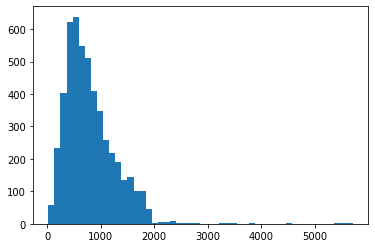

In [ ]:
fig, axs = plt.subplots(1,1)
axs.hist(alens,bins=50)

Looks log-normal, typical abstract is around 700 characters long. This is useful to keep in mind when we train a language model.